In [18]:
# Cell 1: Install libraries and Load Data
!pip install -q transformers datasets torch torchvision scikit-learn matplotlib pillow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import ViltProcessor, ViltForQuestionAnswering, AutoTokenizer, AutoModel
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 下载数据
print("Loading VQA-RAD dataset...")
dataset = load_dataset("flaviagiammarino/vqa-rad")
train_dataset = dataset['train']
test_dataset = dataset['test']

# 2. === 答案清洗函数 ===
def clean_text(text):
    if isinstance(text, str):
        text = text.lower().strip().replace(".", "").replace(",", "").replace("?", "")
        if text in ["yes", "y"]: return "yes"
        if text in ["no", "n"]: return "no"
        return text
    return str(text)

# 统计所有答案的出现频率
all_answers_raw = [clean_text(item['answer']) for item in train_dataset]
answer_counts = Counter(all_answers_raw)

# === 只保留出现次数最多的前 100 个答案 ===
top_k = 100
top_answers = {k for k, v in answer_counts.most_common(top_k)}
top_answers.add('yes')
top_answers.add('no')

# 重新构建 label map
answer_space = sorted(list(top_answers))
label2id = {label: idx for idx, label in enumerate(answer_space)}
id2label = {idx: label for idx, label in enumerate(answer_space)}
num_labels = len(answer_space)

print(f"Total unique answers after filtering: {num_labels} (Reduced from original space)")

def map_answer_to_label(text):
    cleaned = clean_text(text)
    if cleaned in label2id:
        return label2id[cleaned]
    return None

Loading VQA-RAD dataset...
Total unique answers after filtering: 100 (Reduced from original space)


In [19]:
# Cell 2: Define Dataset Class
# 定义增强策略
train_transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MedicalVQADataset(Dataset):
    def __init__(self, hf_dataset, transform=None, tokenizer=None, mode='baseline', processor=None, is_train=False):
        self.dataset = hf_dataset
        self.transform = transform
        self.tokenizer = tokenizer
        self.mode = mode
        self.processor = processor
        self.is_train = is_train

        # 预先筛选掉那些答案不在 Top-K 里的样本
        self.indices = []
        for i, item in enumerate(self.dataset):
            label = map_answer_to_label(item['answer'])
            if label is not None:
                self.indices.append(i)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        item = self.dataset[real_idx]
        image = item['image'].convert("RGB")
        question = item['question']

        # 获取 Label
        label = map_answer_to_label(item['answer'])

        # === Mode A: Baseline (升级版: 使用 BERT Tokenizer) ===
        if self.mode == 'baseline':
            if self.transform:
                image = self.transform(image)

            encoding = self.tokenizer(
                question,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=32
            )

            return {
                'image': image,
                'input_ids': encoding['input_ids'].squeeze(),
                'attention_mask': encoding['attention_mask'].squeeze(),
                'label': torch.tensor(label, dtype=torch.long)
            }

        # === Mode B: ViLT (保持不变) ===
        elif self.mode == 'vilt':
            image = image.resize((384, 384)) # ViLT 需要 384
            if self.is_train and torch.rand(1) > 0.5:
                 image = image.transpose(Image.FLIP_LEFT_RIGHT)

            encoding = self.processor(image, question, return_tensors="pt", padding="max_length", truncation=True, max_length=40)
            for k, v in encoding.items():
                encoding[k] = v.squeeze()
            encoding['labels'] = torch.tensor(label, dtype=torch.long)
            return encoding

In [20]:
# Cell 3: Define Better Baseline Model
print("Loading ClinicalBERT Tokenizer...")
baseline_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

class BaselineVQA(nn.Module):
    def __init__(self, num_classes):
        super(BaselineVQA, self).__init__()

        # 1. Image Encoder: ResNet50
        resnet = models.resnet50(pretrained=True)
        # 去掉分类头
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.visual_dim = 2048

        # 2. Text Encoder: Bio_ClinicalBERT
        self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.text_dim = 768

        # 3. Fusion & Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.visual_dim + self.text_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # Image Features
        img_feat = self.resnet(image)
        img_feat = img_feat.view(img_feat.size(0), -1)

        # Text Features (BERT)
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # 取 [CLS] token 的向量作为整句表示
        txt_feat = text_output.last_hidden_state[:, 0, :]

        # Concatenate
        combined = torch.cat((img_feat, txt_feat), dim=1)

        # Predict
        output = self.classifier(combined)
        return output

# 初始化 Baseline
baseline_model = BaselineVQA(num_classes=num_labels).to(device)
print("Better Baseline Model (ResNet+BioBERT) Initialized.")

Loading ClinicalBERT Tokenizer...


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Better Baseline Model (ResNet+BioBERT) Initialized.


In [21]:
# Cell 4: Define Advanced Model (ViLT with Better Weights)

# 使用在 VQA 任务上微调过的权重
vilt_checkpoint = "dandelin/vilt-b32-finetuned-vqa"

# Load Processor
processor = ViltProcessor.from_pretrained(vilt_checkpoint)

# Load Model
vilt_model = ViltForQuestionAnswering.from_pretrained(
    vilt_checkpoint,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)
vilt_model.to(device)
print("ViLT Model Loaded (Pretrained on General VQA).")

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/470M [00:00<?, ?B/s]

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-finetuned-vqa and are newly initialized because the shapes did not match:
- classifier.3.weight: found shape torch.Size([3129, 1536]) in the checkpoint and torch.Size([100, 1536]) in the model instantiated
- classifier.3.bias: found shape torch.Size([3129]) in the checkpoint and torch.Size([100]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViLT Model Loaded (Pretrained on General VQA).


In [26]:
# Cell 5: Define Train and Evaluation Engine
import torch
from tqdm import tqdm

# === 1. 定义训练函数 ===
def train_engine(model, train_loader, optimizer, criterion, epochs=10, model_name="Baseline"):
    model.train()
    loss_history = []

    print(f"Starting training for {model_name}...")

    for epoch in range(epochs):
        running_loss = 0.0
        loop = tqdm(train_loader, leave=True)

        for batch in loop:
            optimizer.zero_grad()

            if model_name == "Baseline":
                # Baseline: 传入 input_ids 和 attention_mask
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images, input_ids, attention_mask)
                loss = criterion(outputs, labels)

            else:
                # === ViLT ===
                input_ids = batch['input_ids'].to(device)
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values)

                loss = criterion(outputs.logits, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_description(f"Epoch {epoch+1}/{epochs}")
            loop.set_postfix(loss=loss.item())

        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

    return loss_history

# === 2. 评估函数 ===
def evaluate_engine(model, test_loader, model_name="Model"):
    model.eval()
    total_correct = 0
    total_samples = 0
    closed_correct = 0
    closed_total = 0
    open_correct = 0
    open_total = 0
    yes_no_answers = {'yes', 'no'}

    print(f"Evaluating {model_name}...")

    with torch.no_grad():
        for batch in tqdm(test_loader):
            if model_name == "Baseline":
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                outputs = model(images, input_ids, attention_mask)
                _, predicted_ids = torch.max(outputs, 1)
            else: # ViLT
                input_ids = batch['input_ids'].to(device)
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, pixel_values=pixel_values)
                logits = outputs.logits
                _, predicted_ids = torch.max(logits, 1)

            predicted_ids = predicted_ids.cpu().numpy()
            labels = labels.cpu().numpy()

            for i in range(len(labels)):
                true_label_idx = labels[i]
                pred_label_idx = predicted_ids[i]
                if true_label_idx in id2label:
                    true_answer_text = id2label[true_label_idx]
                else:
                    continue
                is_closed = true_answer_text in yes_no_answers
                is_correct = (pred_label_idx == true_label_idx)
                total_samples += 1
                if is_correct:
                    total_correct += 1
                if is_closed:
                    closed_total += 1
                    if is_correct:
                        closed_correct += 1
                else:
                    open_total += 1
                    if is_correct:
                        open_correct += 1

    acc_total = 100 * total_correct / total_samples if total_samples > 0 else 0
    acc_closed = 100 * closed_correct / closed_total if closed_total > 0 else 0
    acc_open = 100 * open_correct / open_total if open_total > 0 else 0

    print(f"[{model_name}] Results:")
    print(f"  - Overall Accuracy: {acc_total:.2f}%")
    print(f"  - Closed-ended (Yes/No): {acc_closed:.2f}% (Count: {closed_total})")
    print(f"  - Open-ended (Others):   {acc_open:.2f}% (Count: {open_total})")

    return acc_total, acc_closed, acc_open

In [27]:
# Cell 6: Execution (Updated)

# 1. Prepare Loaders
train_ds_base = MedicalVQADataset(train_dataset, transform=train_transform_base, tokenizer=baseline_tokenizer, mode='baseline', is_train=True)
test_ds_base = MedicalVQADataset(test_dataset, transform=val_transform_base, tokenizer=baseline_tokenizer, mode='baseline', is_train=False)

train_loader_base = DataLoader(train_ds_base, batch_size=32, shuffle=True)
test_loader_base = DataLoader(test_ds_base, batch_size=32, shuffle=False)

# ViLT 部分保持不变
train_ds_vilt = MedicalVQADataset(train_dataset, processor=processor, mode='vilt', is_train=True)
test_ds_vilt = MedicalVQADataset(test_dataset, processor=processor, mode='vilt', is_train=False)

train_loader_vilt = DataLoader(train_ds_vilt, batch_size=8, shuffle=True)
test_loader_vilt = DataLoader(test_ds_vilt, batch_size=8, shuffle=False)

# 2. Train Baseline (ResNet + BioBERT)
optimizer_base = optim.Adam(baseline_model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

print("\n=== Training Baseline (ResNet + BioBERT) ===")
loss_base = train_engine(baseline_model, train_loader_base, optimizer_base, criterion, epochs=15, model_name="Baseline")

# 3. Train ViLT (Pretrained VQA)
optimizer_vilt = optim.AdamW(vilt_model.parameters(), lr=2e-5)
print("\n=== Fine-tuning ViLT (Transformer) ===")
loss_vilt = train_engine(vilt_model, train_loader_vilt, optimizer_vilt, criterion, epochs=15, model_name="ViLT")

# 4. Final Evaluation
print("\n=== Final Results ===")
acc_base, closed_base, open_base = evaluate_engine(baseline_model, test_loader_base, model_name="Baseline")
acc_vilt, closed_vilt, open_vilt = evaluate_engine(vilt_model, test_loader_vilt, model_name="ViLT")


=== Training Baseline (ResNet + BioBERT) ===
Starting training for Baseline...


Epoch 1/15: 100%|██████████| 42/42 [00:33<00:00,  1.25it/s, loss=0.222]


Epoch 1 Loss: 0.1549


Epoch 2/15: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s, loss=0.0873]


Epoch 2 Loss: 0.1039


Epoch 3/15: 100%|██████████| 42/42 [00:33<00:00,  1.26it/s, loss=0.0441]


Epoch 3 Loss: 0.0870


Epoch 4/15: 100%|██████████| 42/42 [00:33<00:00,  1.27it/s, loss=0.0955]


Epoch 4 Loss: 0.1154


Epoch 5/15: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s, loss=0.0245]


Epoch 5 Loss: 0.0906


Epoch 6/15: 100%|██████████| 42/42 [00:33<00:00,  1.27it/s, loss=0.0616]


Epoch 6 Loss: 0.0628


Epoch 7/15: 100%|██████████| 42/42 [00:32<00:00,  1.27it/s, loss=0.0306]


Epoch 7 Loss: 0.0756


Epoch 8/15: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s, loss=0.111]


Epoch 8 Loss: 0.0675


Epoch 9/15: 100%|██████████| 42/42 [00:32<00:00,  1.29it/s, loss=0.0547]


Epoch 9 Loss: 0.0459


Epoch 10/15: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s, loss=0.0462]


Epoch 10 Loss: 0.0411


Epoch 11/15: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s, loss=0.0844]


Epoch 11 Loss: 0.0280


Epoch 12/15: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s, loss=0.0143]


Epoch 12 Loss: 0.0175


Epoch 13/15: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s, loss=0.0993]


Epoch 13 Loss: 0.0238


Epoch 14/15: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s, loss=0.0112]


Epoch 14 Loss: 0.0175


Epoch 15/15: 100%|██████████| 42/42 [00:32<00:00,  1.28it/s, loss=0.00208]


Epoch 15 Loss: 0.0115

=== Fine-tuning ViLT (Transformer) ===
Starting training for ViLT...


Epoch 1/15: 100%|██████████| 168/168 [01:13<00:00,  2.29it/s, loss=1.88]


Epoch 1 Loss: 2.5327


Epoch 2/15: 100%|██████████| 168/168 [01:12<00:00,  2.30it/s, loss=1.72]


Epoch 2 Loss: 1.7792


Epoch 3/15: 100%|██████████| 168/168 [01:13<00:00,  2.30it/s, loss=0.33]


Epoch 3 Loss: 1.5433


Epoch 4/15: 100%|██████████| 168/168 [01:12<00:00,  2.30it/s, loss=2.34]


Epoch 4 Loss: 1.3295


Epoch 5/15: 100%|██████████| 168/168 [01:12<00:00,  2.30it/s, loss=1.85]


Epoch 5 Loss: 1.1008


Epoch 6/15: 100%|██████████| 168/168 [01:12<00:00,  2.30it/s, loss=0.564]


Epoch 6 Loss: 0.9333


Epoch 7/15: 100%|██████████| 168/168 [01:12<00:00,  2.30it/s, loss=0.832]


Epoch 7 Loss: 0.7586


Epoch 8/15: 100%|██████████| 168/168 [01:12<00:00,  2.30it/s, loss=0.291]


Epoch 8 Loss: 0.6951


Epoch 9/15: 100%|██████████| 168/168 [01:13<00:00,  2.30it/s, loss=0.433]


Epoch 9 Loss: 0.5807


Epoch 10/15: 100%|██████████| 168/168 [01:12<00:00,  2.30it/s, loss=0.0841]


Epoch 10 Loss: 0.5081


Epoch 11/15: 100%|██████████| 168/168 [01:13<00:00,  2.28it/s, loss=0.611]


Epoch 11 Loss: 0.4487


Epoch 12/15: 100%|██████████| 168/168 [01:13<00:00,  2.28it/s, loss=0.381]


Epoch 12 Loss: 0.3983


Epoch 13/15: 100%|██████████| 168/168 [01:13<00:00,  2.27it/s, loss=0.492]


Epoch 13 Loss: 0.3212


Epoch 14/15: 100%|██████████| 168/168 [01:13<00:00,  2.28it/s, loss=0.381]


Epoch 14 Loss: 0.2759


Epoch 15/15: 100%|██████████| 168/168 [01:13<00:00,  2.28it/s, loss=0.318]


Epoch 15 Loss: 0.2442

=== Final Results ===
Evaluating Baseline...


100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


[Baseline] Results:
  - Overall Accuracy: 59.18%
  - Closed-ended (Yes/No): 63.75% (Count: 251)
  - Open-ended (Others):   41.54% (Count: 65)
Evaluating ViLT...


100%|██████████| 40/40 [00:09<00:00,  4.09it/s]

[ViLT] Results:
  - Overall Accuracy: 60.13%
  - Closed-ended (Yes/No): 64.14% (Count: 251)
  - Open-ended (Others):   44.62% (Count: 65)


✅ Loss 曲线已生成，文件名为 'training_loss_curve.png'


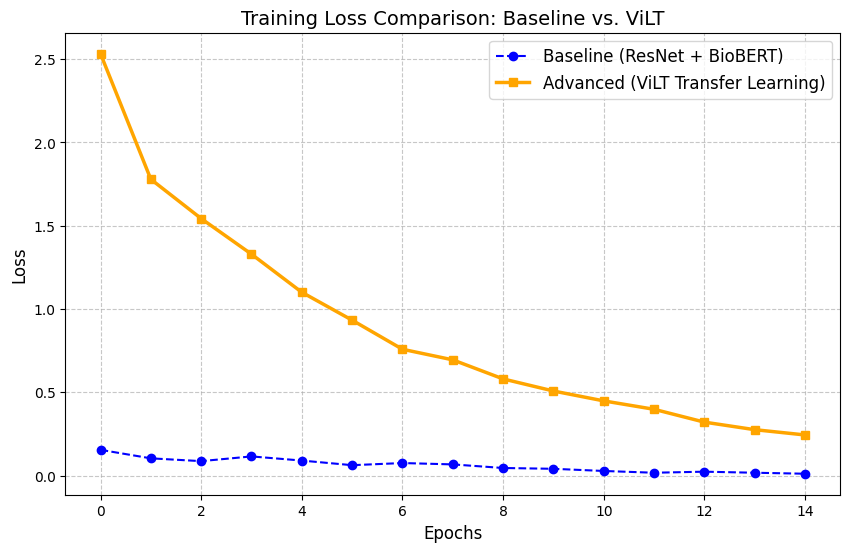

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# 绘制 Baseline 曲线
plt.plot(loss_base, label='Baseline (ResNet + BioBERT)', color='blue', linestyle='--', marker='o')

# 绘制 ViLT 曲线
plt.plot(loss_vilt, label='Advanced (ViLT Transfer Learning)', color='orange', linewidth=2.5, marker='s')

plt.title('Training Loss Comparison: Baseline vs. ViLT', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 保存图片
plt.savefig('training_loss_curve.png', dpi=300)
print("✅ Loss 曲线已生成，文件名为 'training_loss_curve.png'")
plt.show()

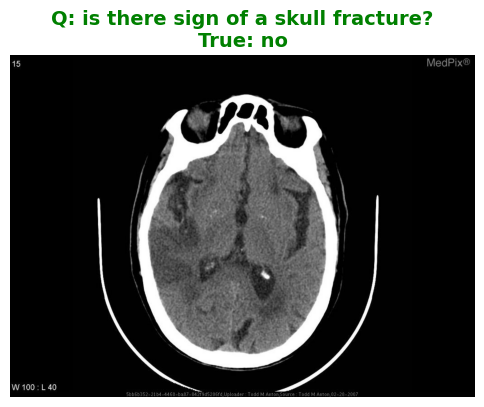

=== Case Index: 196 ===
❓ Question: is there sign of a skull fracture?
✅ True Answer: no
------------------------------
🤖 Baseline Prediction: yes  [❌ WRONG]
🚀 ViLT Prediction:     no  [✅ CORRECT]
------------------------------
🎉 This is an example where ViLT is correct while Baseline is wrong (Success Case)！


In [34]:
import random
import numpy as np

# 逆归一化函数
def unnormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

def find_interesting_case(dataset_raw, idx=None):
    # 1. 随机选一张图
    if idx is None:
        idx = random.randint(0, len(dataset_raw) - 1)

    item = dataset_raw[idx]
    image_raw = item['image'].convert("RGB")
    question = item['question']
    true_answer = clean_text(item['answer'])

    if true_answer not in label2id:
        print(f"Index {idx}: Answer '{true_answer}' not in top-k classes. Skipping...")
        return

    # 2. 让 Baseline 预测
    # 准备输入
    img_tensor = val_transform_base(image_raw).unsqueeze(0).to(device)
    encoding = baseline_tokenizer(question, return_tensors="pt", padding="max_length", truncation=True, max_length=32)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    baseline_model.eval()
    with torch.no_grad():
        out = baseline_model(img_tensor, input_ids, attention_mask)
        pred_idx_base = torch.argmax(out, 1).item()
        pred_base = id2label[pred_idx_base]

    # 3. 让 ViLT 预测
    encoding_vilt = processor(image_raw, question, return_tensors="pt", padding="max_length", truncation=True, max_length=40)
    input_ids_v = encoding_vilt['input_ids'].to(device)
    pixel_values_v = encoding_vilt['pixel_values'].to(device)

    vilt_model.eval()
    with torch.no_grad():
        out_v = vilt_model(input_ids=input_ids_v, pixel_values=pixel_values_v)
        pred_idx_vilt = torch.argmax(out_v.logits, 1).item()
        pred_vilt = id2label[pred_idx_vilt]

    # 4. 显示结果
    plt.figure(figsize=(6, 6))
    plt.imshow(image_raw)
    plt.axis('off')
    plt.title(f"Q: {question}\nTrue: {true_answer}", color='green', fontsize=14, fontweight='bold')
    plt.show()

    # 打印对比结果
    print(f"=== Case Index: {idx} ===")
    print(f"❓ Question: {question}")
    print(f"✅ True Answer: {true_answer}")
    print("-" * 30)

    # 判定颜色
    status_base = "✅ CORRECT" if pred_base == true_answer else "❌ WRONG"
    status_vilt = "✅ CORRECT" if pred_vilt == true_answer else "❌ WRONG"

    print(f"🤖 Baseline Prediction: {pred_base}  [{status_base}]")
    print(f"🚀 ViLT Prediction:     {pred_vilt}  [{status_vilt}]")
    print("-" * 30)

    # 提示用户
    if pred_base != true_answer and pred_vilt == true_answer:
        print("🎉 This is an example where ViLT is correct while Baseline is wrong (Success Case)！")
    elif pred_base != true_answer and pred_vilt != true_answer:
        print("📉 Both are wrong.")

find_interesting_case(test_dataset)